# Using Climate Data - Section 3: Exploring Impacts through Data

Lets now look at how we might start answering the questions around impacts using the UKCP18 climate data. We look at extracting relevant data for our example climate impact use cases.

* Created by Stephen Haddad and Maria Athanassiadou
* Organisation - Met Office Informatics Lab

In [1]:
import pathlib
import datetime
import calendar
import os.path

In [2]:
import boto3
import s3fs
import botocore

In [3]:
import pandas
import xarray
import iris
import iris.analysis
import iris.quickplot

In [4]:
import matplotlib
import matplotlib.pyplot
import seaborn

## Reading the data

To make the process easier, we have condensed the data down to particular sites. To do this we have

* selected particular sites
* extracted a time series for that site
* calculate an ensemble mean

Below we will see an example of extracting the site specific ensemble means from the original dataset. The data has previously been downloaded from the CEDA archive to an AWS S3 bucket, containing all the ensemble memebers for all the years for the climate variables we are interesting. We will demonstrate producing ensemble means for one year for a particular site and variable.

We start by setting up the parameters to access the data in the S3 buckets.

In [5]:
impact_lab_bucket_name = 'impactlab-events'
using_climate_data_dir_name = 'using-climate-data'
il_bucket_s3_path = f's3://{impact_lab_bucket_name}'
ucd_s3_path = f'{il_bucket_s3_path}/{using_climate_data_dir_name}'

In [6]:
site_plot_colours = {'cambridge': 'red', 'exeter': 'orange', 'manchester': 'green', 'newcastle': 'blue', 'edinburgh': 'purple'}
site_list = list(site_plot_colours.keys())
var_list = {'rss': 'Surface solar radiation W/m2',
            'sfcWind': 'Surface wind', 
            'tasmax': 'Daily average maximum temperature', 
            'tasmin': 'Daily average minimum temperature',
           }
era_range_list = {'era1': (1981,2000),
                  'era2': (2021, 2040),
                  'era3': (2061, 2080),
                 }
data_type = 'ensm' # abbreviation of ensemble mean

ensemble_member_list = [1,4,5,6,7,8,9,10,11,12,13,15]
data_version = 'v20190731'
scenario = 'rcp85'
data_category = 'land-cpm'
selected_area = 'uk'
res = '2.2km'
freq = 'day'
format_ext = 'nc'

In [7]:
selected_var = 'tasmax'
selected_start_dt = datetime.datetime(2039,12,1)
selected_end_dt = datetime.datetime(2040,11,30)
start_str = f'{selected_start_dt.year:04d}{selected_start_dt.month:02d}{selected_start_dt.day:02d}'
end_str = f'{selected_end_dt.year:04d}{selected_end_dt.month:02d}{selected_end_dt.day:02d}'

In [8]:
fname_template_ukcp_raw = '{selected_var}_{scenario}_{data_category}_{selected_area}_{res}_{ens_member:02d}_{freq}_{start_str}-{end_str}.{format_ext}'

In [9]:
fs1 = s3fs.S3FileSystem()

In [10]:
ens_objs = []
for ens_num in ensemble_member_list:
    selected_fname = fname_template_ukcp_raw.format(selected_var=selected_var,
                                           scenario=scenario,
                                           data_category=data_category,
                                           selected_area=selected_area,
                                           res=res,
                                           ens_member=ens_num,
                                           freq=freq,
                                           start_str=start_str,
                                           end_str=end_str,
                                           format_ext=format_ext,
                                          )
    path1 = f's3://{impact_lab_bucket_name}/{using_climate_data_dir_name}/{selected_var}/{selected_fname}'
    fileObj1 = fs1.open(path1)
    taxmax_obj = xarray.open_dataset(fileObj1, engine='h5netcdf')
    ens_objs += [taxmax_obj]

In [11]:
ensemble_object = xarray.concat(ens_objs, 'ensemble_member')

In [12]:
ensemble_object

<xarray.Dataset>
Dimensions:                     (bnds: 2, ensemble_member: 12, grid_latitude: 606, grid_longitude: 484, time: 360)
Coordinates:
  * ensemble_member             (ensemble_member) int64 1 4 5 6 ... 11 12 13 15
  * time                        (time) object 2039-12-01 12:00:00 ... 2040-11...
  * grid_latitude               (grid_latitude) float64 -4.683 -4.647 ... 8.063
  * grid_longitude              (grid_longitude) float64 353.9 354.0 ... 364.3
    ensemble_member_id          (ensemble_member) |S27 b'HadREM3-RA11M-r001i1...
    latitude                    (grid_latitude, grid_longitude) float64 47.44...
    longitude                   (grid_latitude, grid_longitude) float64 -11.4...
    month_number                (time) int32 12 12 12 12 12 ... 11 11 11 11 11
    year                        (time) int32 2039 2039 2039 ... 2040 2040 2040
    yyyymmdd                    (time) |S64 b'20391201                       ...
Dimensions without coordinates: bnds
Data variables:
    tasmax                      (ensemble_member, time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  (ensemble_member) int32 -2147483647 ... -2147...
    time_bnds                   (ensemble_member, time, bnds) object 2039-12-...
    grid_latitude_bnds          (ensemble_member, grid_latitude, bnds) float64 ...
    grid_longitude_bnds         (ensemble_member, grid_longitude, bnds) float64 ...
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-30T08:13:33
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

In [13]:
exeter_ensemble_mean_2039 = ensemble_object['tasmax'][:,:,129,234].mean('ensemble_member').to_iris()

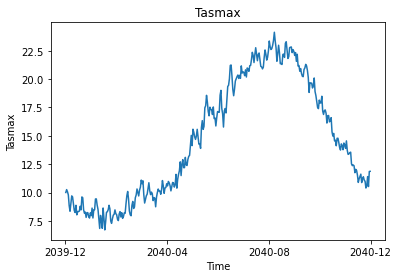

In [14]:
iris.quickplot.plot(exeter_ensemble_mean_2039)

This produces one column of a table for a particular site, a particular era and a particular variable. We repeat this for each of the years in the era to produce the site specific table for that era. We have then produced a table of data with a row for each day of the year and a column for each year. There is a table for each of the variables we are interested, for each of the sites and each of the three eras in the data.

The variables are:
* *rss* - average daily solar radiation
* *sfcWind* - average daily surface wind speed
* *tasmax* - daily maximum surface temperature
* *tasmin* - daily minimum surface temperature

The sites are
* Exeter
* Cambridge
* Manchester
* Newcastle
* Edinburgh

The eras are
* era 1 - 1980-2000
* era 2 - 2020-2040
* era 3 - 2060-2080

In [15]:
site_data_dir = '5sites'
sites_s3_path = f'{ucd_s3_path}/{site_data_dir}'
sites_s3_path

's3://impactlab-events/using-climate-data/5sites'

In [16]:
season_list = {
    0: 'DJF - Winter NH',
    1: 'MAM - Spring NH',
    2: 'JJA - Summer NH',
    3: 'SON - Autumn NH',
}

In [17]:
fname_template = '{var}_{site}_ensm_{era}.csv'

In [18]:
ensm_datasets = {}

From the very large set of data from UKCP, we have selected some variables and extracted ensemble means of daily averages for each day of the year at certain sites of interest (which we have chosen for this demo).

In [19]:
for site in site_list:
    for var in var_list.keys():
        for era_name, era_range in era_range_list.items():
            df1 = pandas.read_csv(sites_s3_path + '/' +  fname_template.format(var=var,
                                                          site=site,
                                                          era=era_name,
                                                         ))
            df1['month'] = (((df1.index // 30) - 1) % 12) +1
            df1['season'] = (df1.index // 30) // 3
            ensm_datasets[(site,var,era_name)] = df1.drop('Unnamed: 0',axis=1)
            

## Energy Production

Lets now look at some questions around the impact of climate change on energy production at our 5 sites across the eras. One aspect of reducing the impacts of climate change is keep further temperature rise to a minimum by reducing our carbon emissions. Part of this is swiotching to renweable energy sources, some of which can be generated invidual homes and business through solar panels. Our impact model for solar energy generation capcity is based on the amount of incoming solar radiation available at the surface. So to see how our solar energy generation capacity will be affected by climate change we need to see how the available solar radiation will vary between the 3 eras in our data at different sites.


### Solar energy

![Solar panels on roofs](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/SoSie%2BSoSchiff_Ansicht.jpg/1280px-SoSie%2BSoSchiff_Ansicht.jpg)

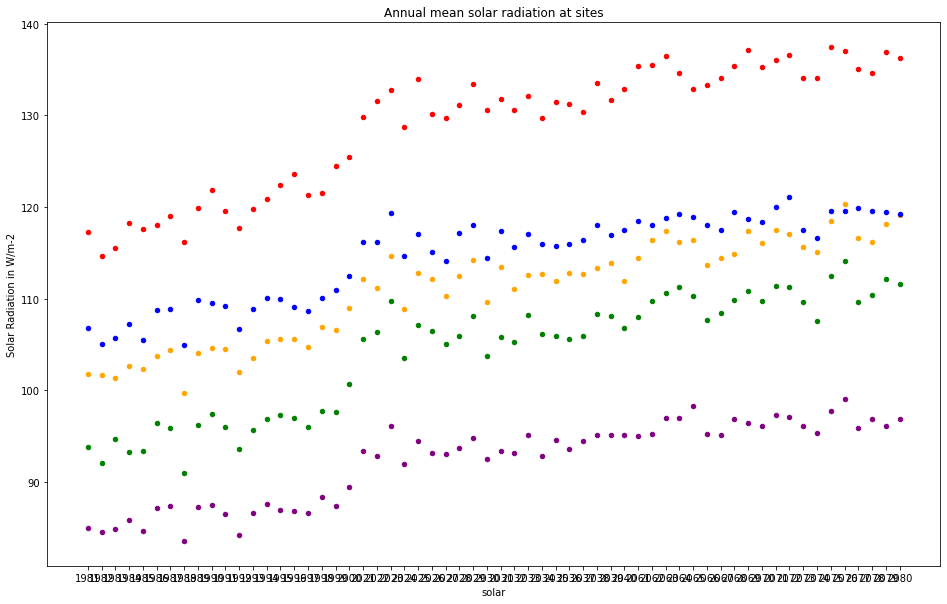

In [20]:
rss_annual_means = pandas.DataFrame(
    {site: pandas.concat([ensm_datasets[site,'rss',era_name].drop(['month','season'],axis=1).transpose().mean(axis=1) for era_name in era_range_list.keys()])
 for site in site_list}
)
rss_annual_means['year'] = rss_annual_means.index
fig_annual_mean_rss = matplotlib.pyplot.figure(f'rss_annual_mean', figsize=(16,10))
ax_annual_mean_rss = fig_annual_mean_rss.add_subplot(1,1,1, title='Annual mean solar radiation at sites')
for site in site_list:
    rss_annual_means.plot.scatter(x='year', y=site, c=site_plot_colours[site], ax=ax_annual_mean_rss, xlabel='solar')
_ = ax_annual_mean_rss.set_ylabel('Solar Radiation in W/m-2')

In [21]:
monthly_averages_exeter = pandas.DataFrame({era_name: ensm_datasets['exeter','rss',era_name].groupby('month').mean().mean(axis=1) for era_name in era_range_list.keys()})
monthly_averages_exeter['month_name'] = [calendar.month_name[ix1] for ix1 in monthly_averages_exeter.index]

<AxesSubplot:title={'center':'Changes in solar radiation for Exeter'}, xlabel='month_name'>

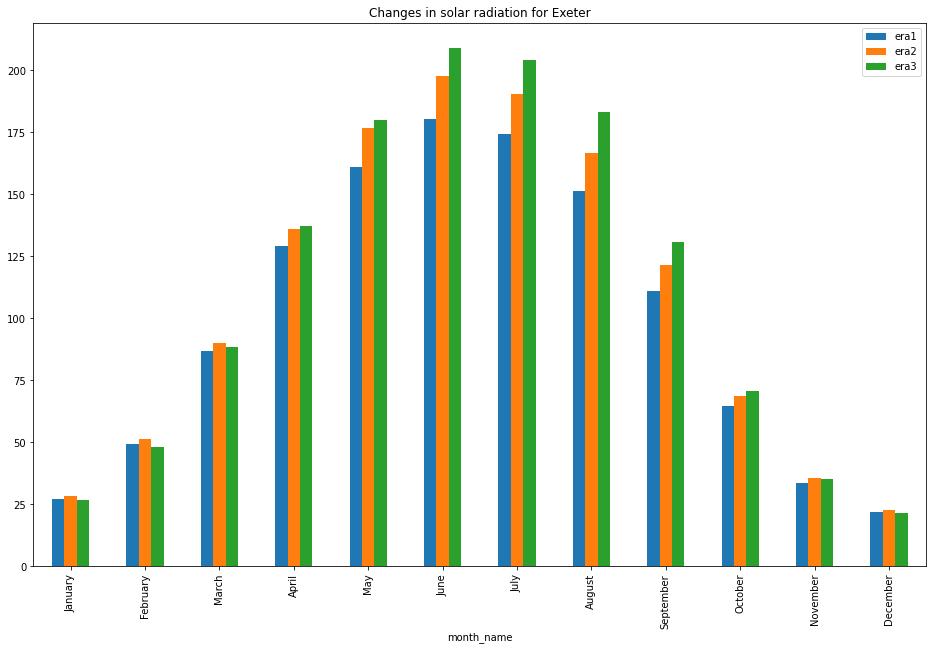

In [22]:
monthly_averages_exeter.plot.bar(x='month_name', figsize=(16,10), title='Changes in solar radiation for Exeter')

In [23]:
monthly_averages_era1 = pandas.DataFrame({site1: ensm_datasets[site1,'rss','era1'].groupby('month').mean().mean(axis=1) for site1 in site_list})
monthly_averages_era3 = pandas.DataFrame({site1: ensm_datasets[site1,'rss','era3'].groupby('month').mean().mean(axis=1) for site1 in site_list})
monthly_averages_era1['month_name'] = [calendar.month_name[ix1] for ix1 in monthly_averages_era1.index]
monthly_averages_era3['month_name'] = [calendar.month_name[ix1] for ix1 in monthly_averages_era3.index]

In [24]:
monthly_averages_era1

,cambridge,exeter,manchester,newcastle,edinburgh,month_name
month,,,,,,
1,27.259640,27.113768,21.432137,21.229999,15.673056,January
2,53.821835,49.256262,43.566077,47.095618,37.326430,February
3,99.962238,86.739176,81.016413,92.922519,74.127187,March
4,152.562990,129.030496,122.987346,142.897210,113.236125,April
5,193.585565,160.752793,158.105992,182.566999,146.687657,May
6,213.837882,180.400166,171.331144,197.924941,162.233650,June
7,205.899513,174.091008,159.852643,187.794740,150.236621,July
8,174.307058,151.145151,135.615184,157.385365,124.102960,August
9,124.657804,110.989527,98.530423,109.517862,86.049121,September


In [25]:
monthly_averages_era3

,cambridge,exeter,manchester,newcastle,edinburgh,month_name
month,,,,,,
1,28.907284,26.511258,21.900567,21.572739,16.075200,January
2,56.097237,48.102595,43.858896,47.946671,37.873737,February
3,104.909583,88.163721,84.160988,96.190595,76.491762,March
4,164.122464,137.132318,134.244416,151.647384,120.945659,April
5,216.210008,179.864805,179.789025,196.518695,163.044247,May
6,244.246820,208.660884,204.187344,218.050759,185.780457,June
7,240.931643,204.036589,194.685457,213.781593,175.256166,July
8,207.836532,182.985736,171.512528,181.490763,148.168723,August
9,146.066177,130.458701,118.143541,124.239297,97.388119,September


(0.0, 250.0)

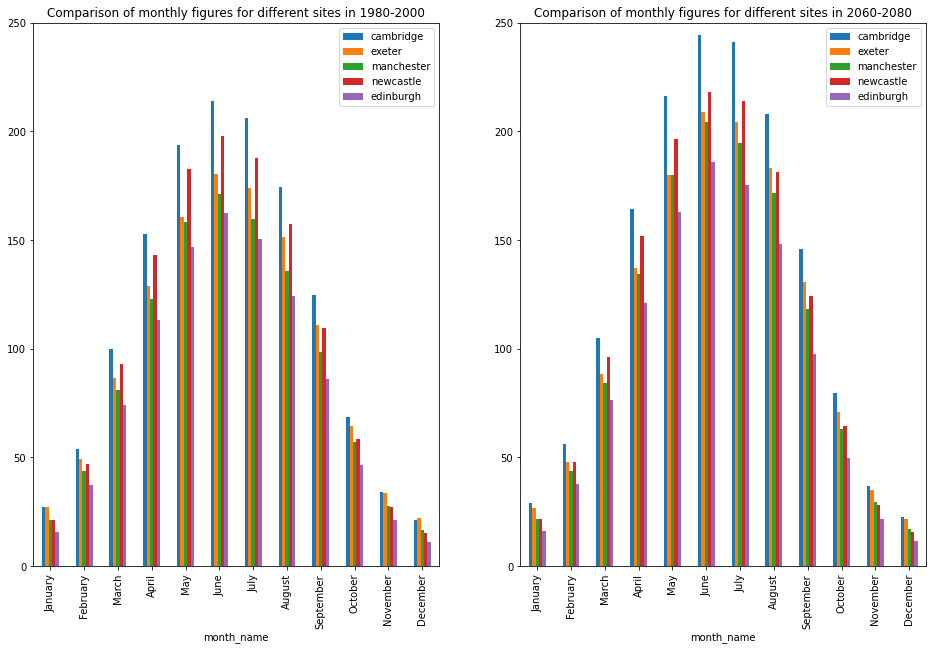

In [26]:
fig1 = matplotlib.pyplot.figure('sites_comparison_rss',figsize=(16,10))
ax1 = fig1.add_subplot(1,2,1, title='Comparison of monthly figures for different sites in 1980-2000')
monthly_averages_era1.plot.bar(x='month_name', ax=ax1)
ax1.set_ylim((0,250))

ax1 = fig1.add_subplot(1,2,2, title='Comparison of monthly figures for different sites in 2060-2080')
monthly_averages_era3.plot.bar(x='month_name', ax=ax1)
ax1.set_ylim((0,250))


In [27]:
cols_by_era = {
    'era1': [str(c1) for c1 in range(*era_range_list['era1'])],
    'era2': [str(c1) for c1 in range(*era_range_list['era2'])],
    'era3': [str(c1) for c1 in range(*era_range_list['era3'])] 
}

In [28]:
rss_stats = {(site1, season1): pandas.DataFrame({era_name: ensm_datasets[(site1,'rss',era_name)][ensm_datasets[(site1,'rss',era_name)].season == season1][cols_by_era[era_name]].stack().reset_index(drop=True) for era_name in era_range_list.keys()}) for season1 in range(4) for site1 in site_list}

In [30]:
solar_bins = {
    0: [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
    1: [100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300],
    2: [100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300],
    3: [0,10,20,30,40,60,80,100,120,140,160, 180,200,220,250],
}

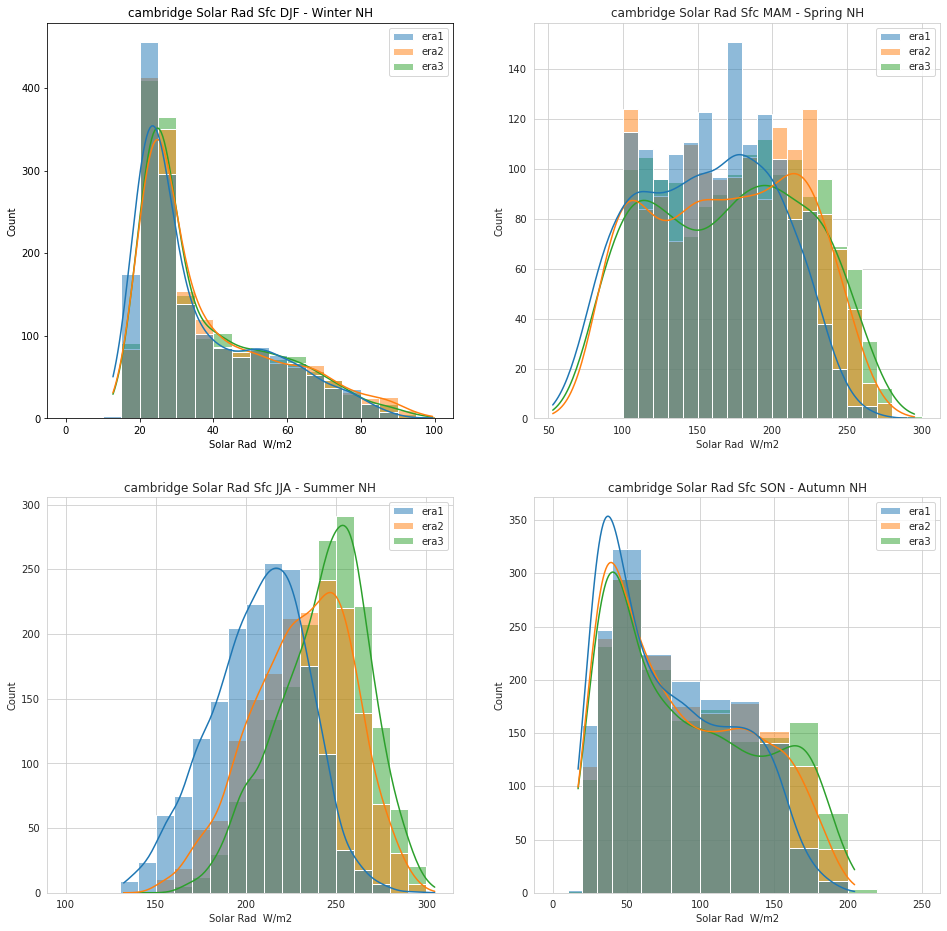

In [31]:
selected_site = site_list[0]
fig1 = matplotlib.pyplot.figure(figsize=(16,16))
for season1, season_name in season_list.items():
    ax1 = fig1.add_subplot(2,2,season1+1,title=f'{selected_site} Solar Rad Sfc {season_name}')
    seaborn.set_style('whitegrid')
    seaborn.histplot(rss_stats[(selected_site, season1)], fill=True, bins=solar_bins[season1],kde=True, ax=ax1)
    ax1.set_xlabel('Solar Rad  W/m2')

So we can see a signal principally in summer for increased solar radiation at the surface. This provides greater opporunity to install solar generating capacity at homes in business to generate electricity in the sumnmer months, making this more economically viable.

### Wind generation - surface wind speed

![Wind farm in Spain](https://upload.wikimedia.org/wikipedia/commons/0/0c/Windpark_Galicia.jpg)

Another form of reneweable energy to consider is wind power. How might the generating capcity of wind power be affected by climate change. Our impact model for wind generation capcity is that generating capcity is proportional to average wind speed. Lets see what our climate projections say about wind speed at our sites.



In [32]:
selected_var = 'sfcWind'

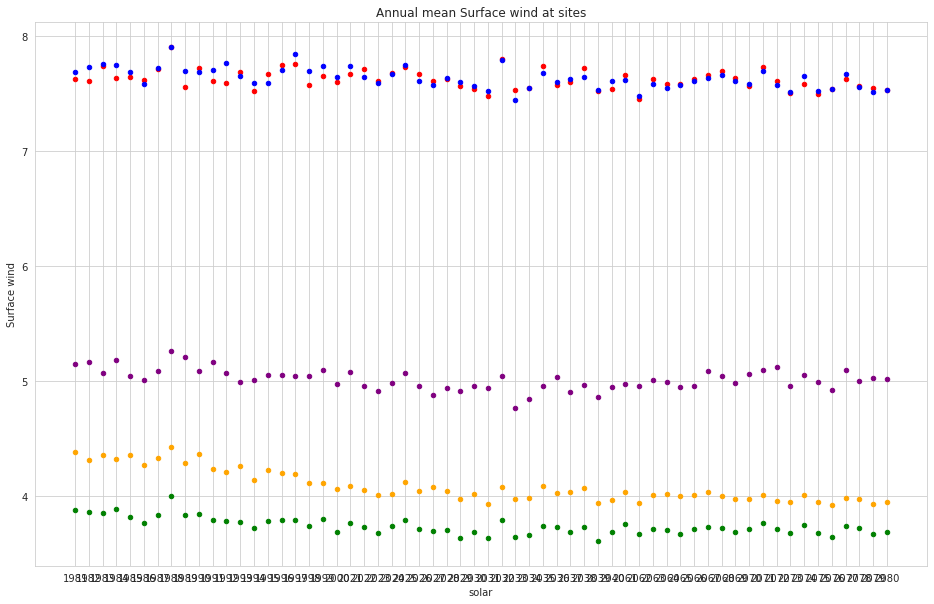

In [33]:
rss_annual_means = pandas.DataFrame(
    {site: pandas.concat([ensm_datasets[site,selected_var,era_name].drop(['month','season'],axis=1).transpose().mean(axis=1) for era_name in era_range_list.keys()])
 for site in site_list}
)
rss_annual_means['year'] = rss_annual_means.index
fig_annual_mean_rss = matplotlib.pyplot.figure(f'{selected_var}_annual_mean', figsize=(16,10))
ax_annual_mean_rss = fig_annual_mean_rss.add_subplot(1,1,1, title=f'Annual mean {var_list[selected_var]} at sites')
for site in site_list:
    rss_annual_means.plot.scatter(x='year', y=site, c=site_plot_colours[site], ax=ax_annual_mean_rss, xlabel='solar')
_ = ax_annual_mean_rss.set_ylabel(var_list[selected_var])

In [34]:
sfcWind_stats = {(site1, season1): pandas.DataFrame({era_name: ensm_datasets[(site1,selected_var,era_name)][ensm_datasets[(site1,selected_var,era_name)].season == season1][cols_by_era[era_name]].stack().reset_index(drop=True) for era_name in era_range_list.keys()}) for season1 in range(4) for site1 in site_list}

In [35]:
wind_bins = {
    0: list(range(0,12,1)),
    1: list(range(0,12,1)),
    2: list(range(0,12,1)),
    3: list(range(0,12,1)),
}

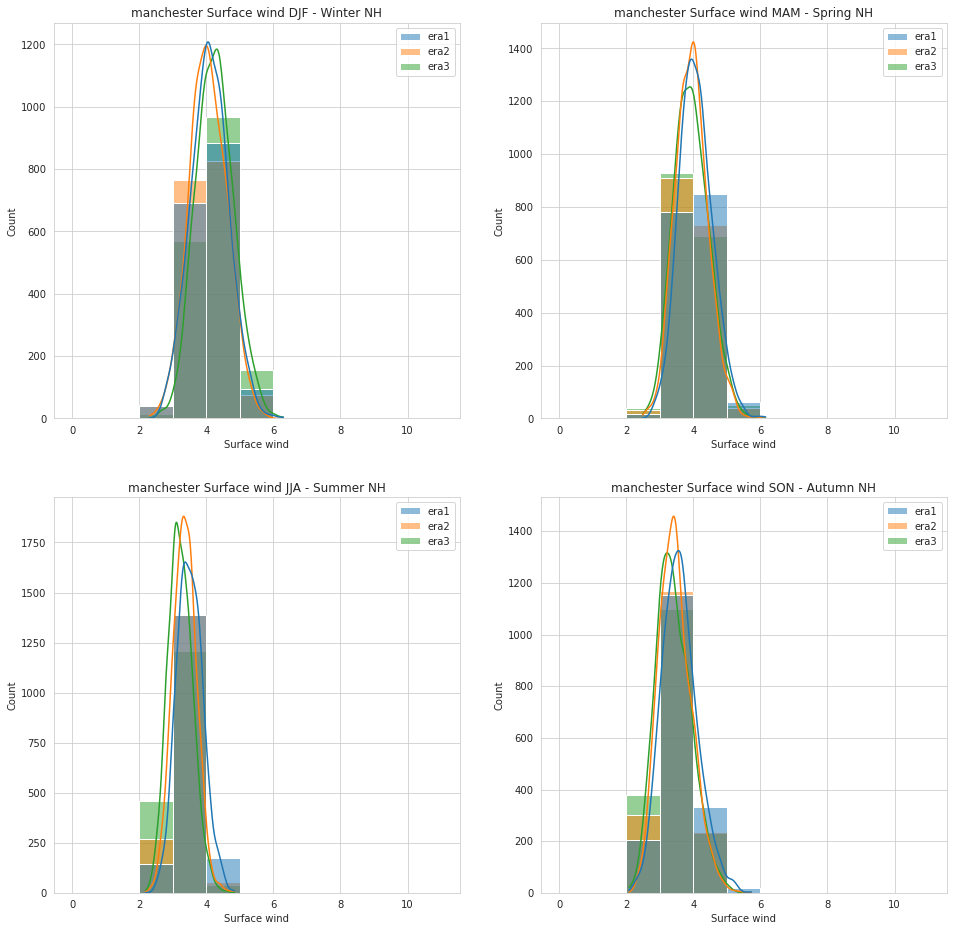

In [36]:
selected_site = site_list[2]
fig1 = matplotlib.pyplot.figure(figsize=(16,16))
for season1, season_name in season_list.items():
    ax1 = fig1.add_subplot(2,2,season1+1,title=f'{selected_site} {var_list[selected_var]} {season_name}')
    seaborn.set_style('whitegrid')
    seaborn.histplot(sfcWind_stats[(selected_site, season1)], fill=True, bins=wind_bins[season1],kde=True, ax=ax1)
    ax1.set_xlabel(var_list[selected_var])

### Heat waves - health and recreation

Higher temperatures are the first thing people in the UK might think in terms of global warming and climate change and its local effects. But what actual impact might higher temperatures have? We need to consider both higher maximum temperatures and higher minimum temperatures.

Higher maximums might mean:
* greater popularity for leisure travel to areas previously thought too cool
* extended season for tourism
* greater chance of heat stress for locals, including employees

Higher minimums
* outdoor hispitality opportunities in the evening
* greater need for artificial cooling as building do not naturally cool as effectively overnight
* less need for artificial heating in autumn/spring

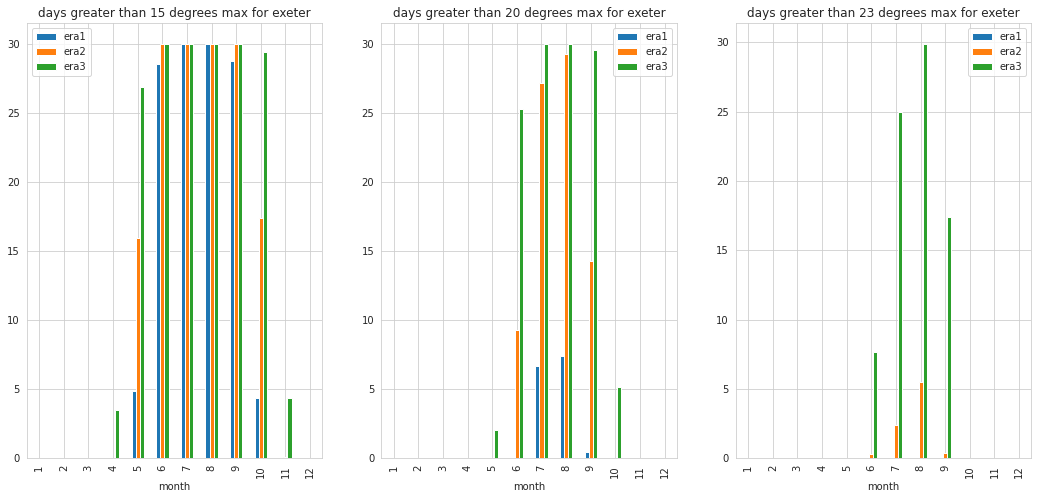

In [38]:
selected_site = 'exeter'
selected_var = 'tasmax'
thresholds = [15,20,23]
fig1 = matplotlib.pyplot.figure('temp max days exeter',figsize=(18,8))
for ix1, t1 in enumerate(thresholds):
    ax1 = fig1.add_subplot(1,3,ix1+1,title=f'days greater than {t1} degrees max for {selected_site}')
    pandas.DataFrame({era_name: (ensm_datasets[(selected_site, selected_var, era_name)][cols_by_era[era_name]] > t1).groupby(ensm_datasets[(selected_site, selected_var, era_name)]['month']).sum().mean(axis=1) for era_name in era_range_list.keys()}).plot.bar(ax=ax1)


Warmer may mean tourists will stay out at restaurants and bars later, using outdoor seating areas, providing greater opportunities for the hospitality sector. Additionally though, warmer nights mean buildings do not cool down over night leading to a buildup of heat, increasing the need for artifical cooling, and associated increase in expense.

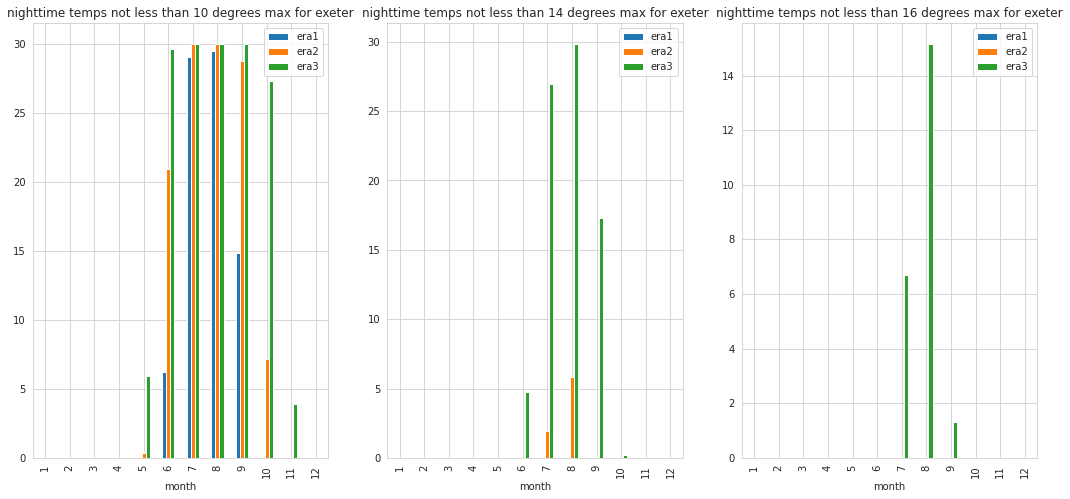

In [39]:
selected_site = 'exeter'
selected_var = 'tasmin'
thresholds = [10,14,16]
fig1 = matplotlib.pyplot.figure('temp min days exeter',figsize=(18,8))
for ix1, t1 in enumerate(thresholds):
    ax1 = fig1.add_subplot(1,3,ix1+1,title=f'nighttime temps not less than {t1} degrees max for {selected_site}')
    pandas.DataFrame({era_name: (ensm_datasets[(selected_site, selected_var, era_name)][cols_by_era[era_name]] > t1).groupby(ensm_datasets[(selected_site, selected_var, era_name)]['month']).sum().mean(axis=1) for era_name in era_range_list.keys()}).plot.bar(ax=ax1)


In [40]:
tasmax_stats = {(site1, season1): pandas.DataFrame({era_name: ensm_datasets[(site1,'tasmax',era_name)][ensm_datasets[(site1,'tasmax',era_name)].season == season1][cols_by_era[era_name]].stack().reset_index(drop=True) for era_name in era_range_list.keys()}) for season1 in range(4) for site1 in site_list}
tasmin_stats = {(site1, season1): pandas.DataFrame({era_name: ensm_datasets[(site1,'tasmin',era_name)][ensm_datasets[(site1,'tasmin',era_name)].season == season1][cols_by_era[era_name]].stack().reset_index(drop=True) for era_name in era_range_list.keys()}) for season1 in range(4) for site1 in site_list}

In [41]:
temp_bins = {
    0: list(range(0,30,2)),
    1: list(range(0,30,2)),
    2: list(range(0,30,2)),
    3: list(range(0,30,2)),
}

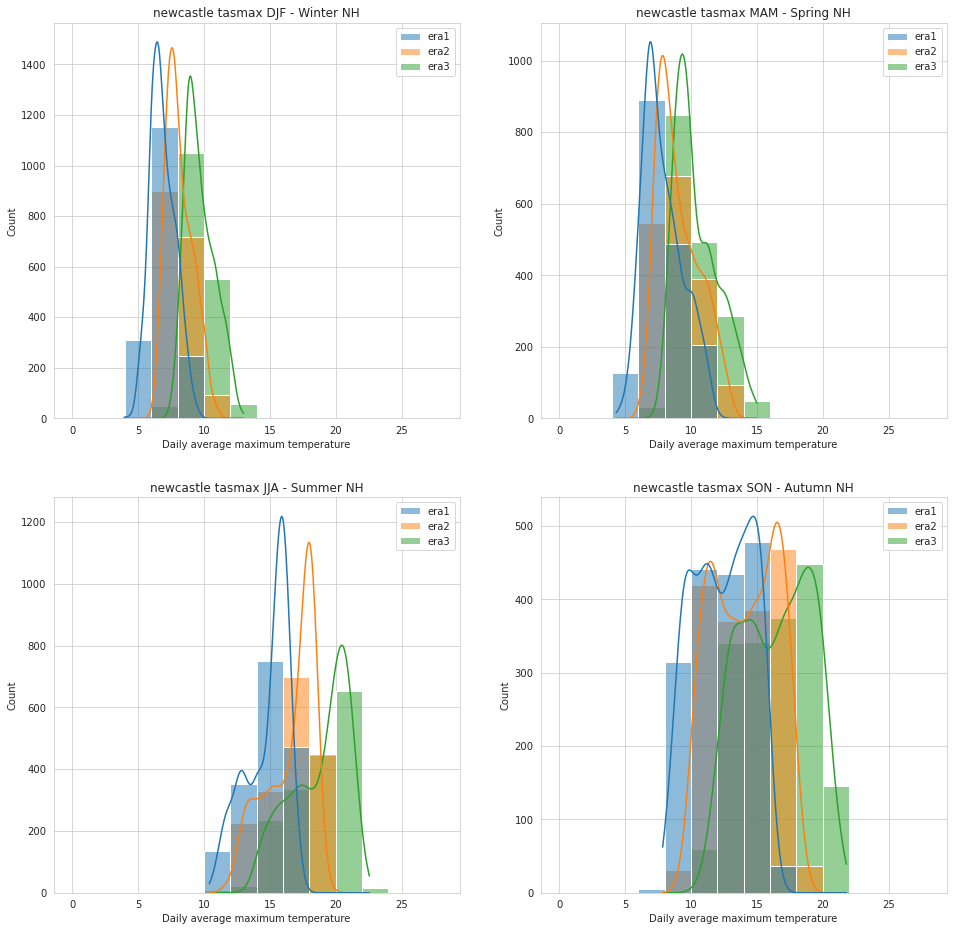

In [42]:
selected_site = site_list[3]
fig1 = matplotlib.pyplot.figure(figsize=(16,16))
for season1, season_name in season_list.items():
    ax1 = fig1.add_subplot(2,2,season1+1,title=f'{selected_site} tasmax {season_name}')
    seaborn.set_style('whitegrid')
    seaborn.histplot(tasmax_stats[(selected_site, season1)], fill=True, bins=temp_bins[season1],kde=True, ax=ax1)
    ax1.set_xlabel(var_list['tasmax'])

In our temperature data we see a clear signal for higher maxima and minima in 2060-2080 compared to 1980-2000. This is most pronounced in the summer but easily visible in all seasons.

## Next steps for exploring Climate Impacts

In what ways might climate change impact your business? To start exploring these impacts using climate data?

* What area of your business do you think might be expected?
* What climate variables might affect this area of your business?
* How might you map from one or more climactic variables to a business impact
  * Is this a known relationship you can easily describe?
  * Do you know there is a relationship or might you need some statistical analysis to consider whether their is indeed a relationship between climate and business variables as per your hypothesis?
  * If there is a relationship, might you be able to use a machine learning technique to learn the relationship from the data?
* Where can you get the relevant data?
  * For climate data, standard datasets such as UKCP18 or CMIP6 should be sufficient for at least initial analysis.
  * For business data, do you collect the data yourself is is their a 3rd party data provider or vendor where you can obtain data that describes the buesiness impacts in sufficient detail.

![Climate data to business impacts pipeline](climate_to_business_impacts.png)
